In [1]:
library(CytoTRACE)
library(anndata)
library(RColorBrewer)

Welcome to the CytoTRACE R package, a tool for the unbiased prediction of differentiation states in scRNA-seq data. For more information about this method, visit https://cytotrace.stanford.edu.


Warning message:
“The ScanoramaCT python module is not accessible. The iCytoTRACE function for integration across multiple datasets will be disabled. Please follow the instructions in https://github.com/gunsagargulati/CytoTRACE to install the necessary Python packages for this application.”


In [2]:
CytoTRACE

function (mat, batch = NULL, enableFast = TRUE, ncores = 1, subsamplesize = 1000) 
{
    range01 <- function(x) {
        (x - min(x))/(max(x) - min(x))
    }
    a1 <- mat
    a2 <- batch
    if (ncol(mat) < 3000) {
        enableFast = FALSE
        message("The number of cells in your dataset is less than 3,000. Fast mode has been disabled.")
    }
    else {
        message("The number of cells in your dataset exceeds 3,000. CytoTRACE will now be run in fast mode (see documentation). You can multi-thread this run using the 'ncores' flag. To disable fast mode, please indicate 'enableFast = FALSE'.")
    }
    pqgenes <- is.na(rowSums(mat > 0)) | apply(mat, 1, var) == 
        0
    num_pqgenes <- length(which(pqgenes == TRUE))
    mat <- mat[!pqgenes, ]
    if (num_pqgenes > 0) {
        warning(paste(num_pqgenes, "genes have zero expression in the matrix and were filtered"))
    }
    if (enableFast == FALSE) {
        size <- ncol(mat)
    }
    else if (enableFast == TRUE & subsamplesize < ncol(mat)) {
        size <- subsamplesize
    }
    else if (enableFast == TRUE & subsamplesize >= ncol(mat)) {
        stop("Please choose a subsample size less than the number of cells in dataset.")
    }
    chunk <- round(ncol(mat)/size)
    subsamples <- split(1:ncol(mat), sample(factor(1:ncol(mat)%%chunk)))
    message(paste("CytoTRACE will be run on", chunk, "sub-sample(s) of approximately", 
        round(mean(unlist(lapply(subsamples, length)))), "cells each using", 
        min(chunk, ncores), "/", ncores, "core(s)"))
    message(paste("Pre-processing data and generating similarity matrix..."))
    batches <- parallel::mclapply(subsamples, mc.cores = min(chunk, 
        ncores), function(subsample) {
        mat <- mat[, subsample]
        batch <- batch[subsample]
        if (max(mat) < 50) {
            mat <- 2^mat - 1
        }
        if (length(grep("ERCC-", rownames(mat))) > 0) {
            mat <- mat[-grep("ERCC-", rownames(mat)), ]
        }
        mat <- t(t(mat)/apply(mat, 2, sum)) * 1e+06
        pqcells <- is.na(apply(mat > 0, 2, sum)) | apply(mat > 
            0, 2, sum) <= 10
        num_pqcells <- length(which(pqcells == TRUE))
        mat <- mat[, !pqcells]
        mat <- log(mat + 1, 2)
        mat <- data.matrix(mat)
        counts <- apply(mat > 0, 2, sum)
        if (ncol(a1) == length(a2)) {
            batch <- batch[!pqcells]
            suppressMessages(mat <- sva::ComBat(mat, batch, c()))
            mat <- data.matrix(mat)
            mat[which(mat < 0)] <- 0
        }
        census_normalize <- function(mat, counts) {
            xnl <- 2^data.matrix(mat) - 1
            rs <- apply(xnl, 2, sum)
            rnorm <- t(t(xnl) * counts/rs)
            A <- log(rnorm + 1, 2)
            return(A)
        }
        mat2 <- census_normalize(mat, counts)
        mvg <- function(matn) {
            A <- matn
            n_expr <- rowSums(A > 0)
            A_filt <- A[n_expr >= 0.05 * ncol(A), ]
            vars <- apply(A_filt, 1, var)
            means <- apply(A_filt, 1, mean)
            disp <- vars/means
            last_disp <- tail(sort(disp), 1000)[1]
            A_filt <- A_filt[disp >= last_disp, ]
            return(A_filt)
        }
        mat2.mvg <- mvg(mat2)
        rm1 <- colSums(mat2.mvg) == 0
        mat2 <- mat2[, !rm1]
        counts <- counts[!rm1]
        similarity_matrix_cleaned <- function(similarity_matrix) {
            D <- similarity_matrix
            cutoff <- mean(as.vector(D))
            diag(D) <- 0
            D[which(D < 0)] <- 0
            D[which(D <= cutoff)] <- 0
            Ds <- D
            D <- D/rowSums(D)
            D[which(rowSums(Ds) == 0), ] <- 0
            return(D)
        }
        D <- similarity_matrix_cleaned(HiClimR::fastCor(mvg(mat2)))
        return(list(mat2 = mat2, counts = counts, D = D))
    })
    mat2 <- do.call(cbind, lapply(batches, function(x) x$mat2))
    counts <- do.call(c, lapply(batches, function(x) x$counts))
    filter <

In [3]:
# Load fibroblast data
adata = read_h5ad('../data/rna/scRNA_batch1_2.processed.fibroblasts.h5ad')

In [4]:
adata

AnnData object with n_obs × n_vars = 26727 × 17590
    obs: 'doublet_bh_pval', 'n_counts', 'sample_id', 'scrublet_score', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'percent_top50', 'GEX_SID', 'ATAC_SID', 'GEX', 'ATAC', 'Sample', 'DOB', 'Gender', 'date', 'age_years', 'state', 'disease', 'site_taken_fine', 'site_taken_broad', 'sorted', 'Nancy_histologic_score', 'slide_look_other', 'whole_tissue_signature', 'scSeq', 'bulkSeq', 'annot_batch1_lr', 'annot_batch1_lr_prob', 'annot_batch2_lr', 'annot_batch2_lr_prob', 'leiden_bk_r0_1', 'leiden_bk_r0_3', 'leiden_bk_r0_5', 'is_doublet', 'leiden_bk_split1', 'leiden_bk_split2', 'leiden_bk_split3', 'annot1', 'leiden_bk_split4', 'annot_gut_lr', 'annot_gut_lr_prob', 'broad_annot1'
    var: 'gene_ids', 'mito', 'ribo', 'hb', 'n_counts', 'n_cells', 'cc', 'highly_variable', 'highly_variable_nbatches', 'hvg_full'
    uns: 'annot1_colors', 'leiden', 'neighbors', 'neighbors_bk', 'pca', 'umap'
    obsm: 'X_pca'

In [5]:
# normalized matrix.
# convert to dense matrix
mat = t(data.matrix(adata$X))  # gene x cell matrix

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 3.5 GiB”


In [6]:
dim(mat)

[1] 17590 26727

In [7]:
mat[1:100, 1:10]

,AAACCCATCGTGCTCT-R01,AAACGAACATGTTACG-R01,AAACGAAGTTCCGTTC-R01,AAACGCTGTCGTTGGC-R01,AAAGAACCACAAGGTG-R01,AAAGGGCGTAGAGCTG-R01,AAAGGGCTCCAAGGGA-R01,AAAGGTACAGTCTCTC-R01,AAAGGTATCCGAAGGA-R01,AAAGTCCGTACGATGG-R01
AL627309.1,0.000000,0.000000,0,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000
AL669831.5,0.000000,0.000000,0,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000
FAM87B,0.000000,0.000000,0,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000
LINC00115,0.000000,0.000000,0,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000
FAM41C,0.000000,0.000000,0,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000
AL645608.3,0.000000,0.000000,0,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000
AL645608.1,0.000000,0.000000,0,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000
SAMD11,0.000000,0.000000,0,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000
NOC2L,0.000000,0.000000,0,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000
KLHL17,0.000000,0.000000,0,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.000000


In [8]:
cyto_results = CytoTRACE(mat, ncores=2)

The number of cells in your dataset exceeds 3,000. CytoTRACE will now be run in fast mode (see documentation). You can multi-thread this run using the 'ncores' flag. To disable fast mode, please indicate 'enableFast = FALSE'.

Warning message in CytoTRACE(mat, ncores = 2):
“10 genes have zero expression in the matrix and were filtered”
CytoTRACE will be run on 27 sub-sample(s) of approximately 990 cells each using 2 / 2 core(s)

Pre-processing data and generating similarity matrix...

Calculating gene counts signature...

Smoothing values with NNLS regression and diffusion...

Calculating genes associated with CytoTRACE...

Done



In [9]:
names(cyto_results)

[1] "CytoTRACE"     "CytoTRACErank" "cytoGenes"     "GCS"          
[5] "gcsGenes"      "Counts"        "filteredCells" "exprMatrix"

In [16]:
head(cyto_results$CytoTRACE)

AAACCCATCGTGCTCT-R01 AAACGAACATGTTACG-R01 AAACGAAGTTCCGTTC-R01 
          0.71991911           0.47320526           0.41253792 
AAACGCTGTCGTTGGC-R01 AAAGAACCACAAGGTG-R01 AAAGGGCGTAGAGCTG-R01 
          0.26794742           0.02527806           0.14155713

In [26]:
saveRDS(cyto_results, "results/cyto_results.rds")

In [24]:
# Write CytoTRACE to file
write.csv(
    data.frame(CytoTRACE=cyto_results$CytoTRACE),
    "results/cytotrace.csv")

In [25]:
#cyto_results$GCS

Running t-SNE. To use your own coordinates, use the 'emb' flag.



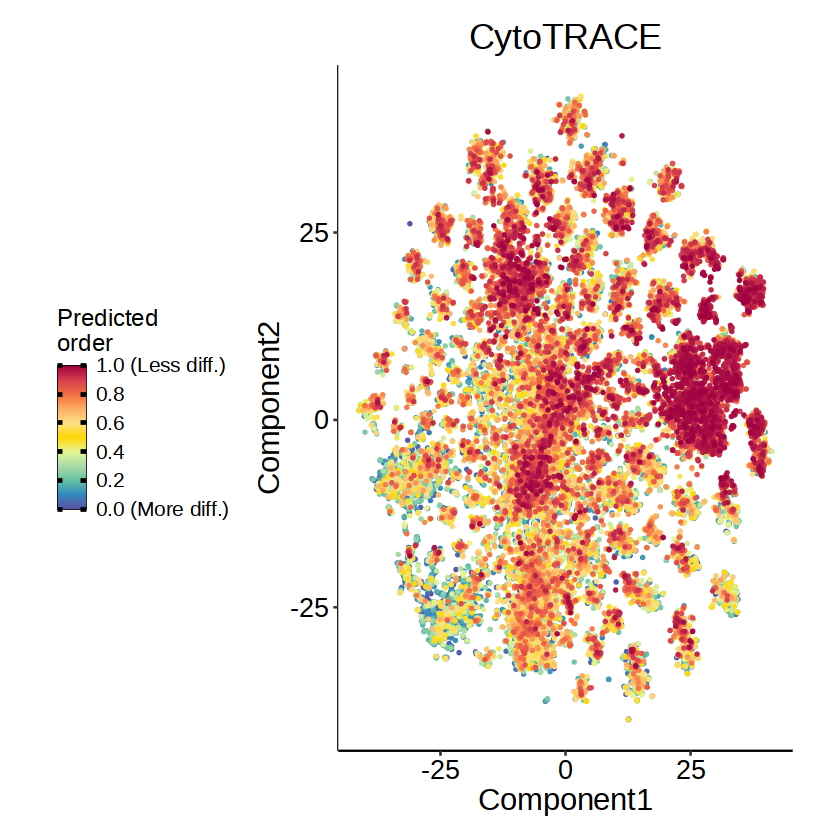

In [10]:
plotCytoTRACE(cyto_results, outputDir="plots/")

In [11]:
plotCytoTRACE(cyto_results, adata$obs$annot1)

ERROR: Error in plotCytoTRACE(cyto_results, adata$obs$annot1): The names of the phenotype labels do no match the names in the CytoTRACE object.error


In [12]:
plotCytoGenes

function (cyto_obj = NULL, numOfGenes = 10, colors = c("darkred", 
    "navyblue"), outputDir = "./") 
{
    cytoGenes <- cyto_obj$cytoGenes
    top_k <- tail(sort(cytoGenes), numOfGenes)
    bottom_k <- head(sort(cytoGenes), numOfGenes)
    final_list <- data.frame(CytoGenes = c(top_k, bottom_k))
    final_list <- cbind(final_list, Gene = rownames(final_list))
    final_list <- final_list[order(final_list$CytoGenes), ]
    p <- ggplot2::ggplot(data = final_list, ggplot2::aes(x = Gene, 
        y = CytoGenes, color = CytoGenes, fill = CytoGenes)) + 
        ggplot2::geom_bar(position = "dodge", stat = "identity") + 
        ggplot2::coord_flip() + ggplot2::scale_color_gradient(low = colors[2], 
        high = colors[1], guide = F) + ggplot2::scale_fill_gradient(low = adjustcolor(colors[2], 
        0.3), high = adjustcolor(colors[1], 0.3), guide = F) + 
        ggplot2::scale_x_discrete(limits = final_list$Gene) + 
        ggplot2::scale_y_continuous(breaks = as.numeric(formatC(round(signif(seq(round(min(cytoGenes, 
            na.rm = T) - 0.05, 1), round(max(cytoGenes, na.rm = T) + 
            0.05, 1), 0.2), 1), 1), digits = 1))) + ggplot2::ylab("Correlation with CytoTRACE") + 
        ggplot2::theme(legend.title = ggplot2::element_blank(), 
            legend.position = "none", legend.background = ggplot2::element_rect(), 
            axis.text.x = ggplot2::element_text(color = "black", 
                size = 15), axis.text.y = ggplot2::element_text(color = "black", 
                size = 15), axis.title.x = ggplot2::element_text(color = "black", 
                size = 20, margin = ggplot2::margin(t = 10, r = 0, 
                  b = 0, l = 0)), axis.title.y = ggplot2::element_text(color = "black", 
                size = 20, margin = ggplot2::margin(t = 0, r = 20, 
                  b = 0, l = 0)), axis.ticks.x = ggplot2::element_line(color = "black"), 
            axis.ticks.y = ggplot2::element_line(color = "black"), 
            axis.ticks.length = ggplot2::unit(0.2, "cm"), strip.background = ggplot2::element_blank(), 
            strip.text = ggplot2::element_text(colour = "black", 
                size = 17), axis.line = ggplot2::element_line(colour = "black"), 
            panel.grid.major = ggplot2::element_blank(), panel.grid.minor = ggplot2::element_blank(), 
            panel.border = ggplot2::element_blank(), panel.background = ggplot2::element_blank(), 
            plot.margin = ggplot2::margin(t = 0.5, r = 0.5, b = 0.5, 
                l = 0.5, unit = "cm"), panel.spacing.x = ggplot2::unit(1.5, 
                "lines"))
    p
    pdf(paste0(outputDir, "CytoGenes.pdf"), width = 7, height = numOfGenes/1.75)
    print(p)
    dev.off()
}
<bytecode: 0x562c60d31800>
<environment: namespace:CytoTRACE>

In [13]:
plotCytoGenesCustom = function (cyto_obj = NULL, numOfGenes = 10, colors = c("darkred", 
    "navyblue"), outputDir = "./") 
{
    cytoGenes <- cyto_obj$cytoGenes
    top_k <- tail(sort(cytoGenes), numOfGenes)
    bottom_k <- head(sort(cytoGenes), numOfGenes)
    final_list <- data.frame(CytoGenes = c(top_k, bottom_k))
    final_list <- cbind(final_list, Gene = rownames(final_list))
    final_list <- final_list[order(final_list$CytoGenes), ]
    p <- ggplot2::ggplot(data = final_list, ggplot2::aes(x = Gene, 
        y = CytoGenes, color = CytoGenes, fill = CytoGenes)) + 
        ggplot2::geom_bar(position = "dodge", stat = "identity") + 
        ggplot2::coord_flip() + ggplot2::scale_color_gradient(low = colors[2], 
        high = colors[1], guide = F) + ggplot2::scale_fill_gradient(low = adjustcolor(colors[2], 
        0.3), high = adjustcolor(colors[1], 0.3), guide = F) + 
        ggplot2::scale_x_discrete(limits = final_list$Gene) + 
        ggplot2::scale_y_continuous(breaks = as.numeric(formatC(round(signif(seq(round(min(cytoGenes, 
            na.rm = T) - 0.05, 1), round(max(cytoGenes, na.rm = T) + 
            0.05, 1), 0.2), 1), 1), digits = 1))) + ggplot2::ylab("Correlation with CytoTRACE") + 
        ggplot2::theme(legend.title = ggplot2::element_blank(), 
            legend.position = "none", legend.background = ggplot2::element_rect(), 
            axis.text.x = ggplot2::element_text(color = "black", 
                size = 15), axis.text.y = ggplot2::element_text(color = "black", 
                size = 15), axis.title.x = ggplot2::element_text(color = "black", 
                size = 20, margin = ggplot2::margin(t = 10, r = 0, 
                  b = 0, l = 0)), axis.title.y = ggplot2::element_text(color = "black", 
                size = 20, margin = ggplot2::margin(t = 0, r = 20, 
                  b = 0, l = 0)), axis.ticks.x = ggplot2::element_line(color = "black"), 
            axis.ticks.y = ggplot2::element_line(color = "black"), 
            axis.ticks.length = ggplot2::unit(0.2, "cm"), strip.background = ggplot2::element_blank(), 
            strip.text = ggplot2::element_text(colour = "black", 
                size = 17), axis.line = ggplot2::element_line(colour = "black"), 
            panel.grid.major = ggplot2::element_blank(), panel.grid.minor = ggplot2::element_blank(), 
            panel.border = ggplot2::element_blank(), panel.background = ggplot2::element_blank(), 
            plot.margin = ggplot2::margin(t = 0.5, r = 0.5, b = 0.5, 
                l = 0.5, unit = "cm"), panel.spacing.x = ggplot2::unit(1.5, 
                "lines"))
    p
    pdf(paste0(outputDir, "CytoGenes.pdf"), width = 6, height = numOfGenes/2.00)  # changed plot dimensiosn from original function
    print(p)
    dev.off()
}

In [14]:
plotCytoGenesCustom(cyto_results, numOfGenes=20, colors=brewer.pal(8, "Set2"), outputDir="plots/")

png 
  2